In [1]:
import os
import numpy as np
from astropy.table import Table, QTable, Column, join
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from astropy import units as u
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Spatially resolved SF relations for EDGE, at 7" resolution (not deprojected)
### We use the 'smo' mask for detections but the 'str' mask for considering non-detections.  These differ in velocity width so we scale the 'str' mask noise down to the median velocity width for the 'smo' mask.

In [2]:
# limit the columns we read to avoid information overload
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
            'e_flux_Hbeta_sm','flux_sigsfr_sm','EW_Halpha_sm']

# Note that NGC 5784 is missing stellar mass
globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMass'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coSmoothDv_smo7'])
try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('edge.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    conomasktab = EdgeTable('NGC4047.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coSmoothDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coSmoothDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)

Median unmasked velocity width is 860.0
Median masked velocity width is 420.0
Noise estimates will be scaled down by 0.6988362419217079


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['emom0_12'] *= nsefactor
conomasktab['emom0_12'].name = 'emom0max_12'
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'flux_sigsfr_sm', 'EW_Halpha_sm', 'mass_ssp_sm', 'sigstar_sm', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'mom0_12', 'emom0_12', 'mom1_12', 'emom1_12', 'mom2_12', 'emom2_12', 'sigmol', 'e_sigmol', 'sigmol_fo', 'e_sigmol_fo', 'mom0_13', 'emom0_13', 'mom1_13', 'emom1_13', 'mom2_13', 'emom2_13', 'emom0max_12', 'caMass']


In [5]:
# Apply a 3-sigma cut to CO, Halpha, Hbeta
codet = (fluxtab['mom0_12']>3*fluxtab['emom0_12'])
sfdet = ((fluxtab['flux_Halpha_sm']>3*fluxtab['e_flux_Halpha_sm']) &
         (fluxtab['flux_Hbeta_sm']>3*fluxtab['e_flux_Hbeta_sm']))
det = codet & sfdet
ndet = ~codet & sfdet

In [6]:
sfe_det = Table()
sfe_det['Name'] = fluxtab['Name'][det]
sfe_det['ICO'] = fluxtab['mom0_12'][det]
sfe_det['IHA'] = fluxtab['flux_Halpha_sm'][det]
sfe_det['sigmol'] = fluxtab['sigmol'][det]
sfe_det['sigsfr'] = fluxtab['flux_sigsfr_sm'][det]
sfe_det['sigstar'] = fluxtab['sigstar_sm'][det]
sfe_det['stmass'] = fluxtab['caMass'][det]
sfe_det['t_dep'] = Column(sfe_det['sigmol'].quantity/sfe_det['sigsfr'].quantity)
sfe_det['sigssfr'] = Column(sfe_det['sigsfr'].quantity/sfe_det['sigstar'].quantity)
sfe_det

Name,ICO,IHA,sigmol,sigsfr,sigstar,stmass,t_dep,sigssfr
,K km / s,1e-16 erg / (cm2 s),solMass / pc2,solMass / (Gyr pc2),solMass / pc2,dex(solMass),Gyr,1 / Gyr
str16,float32,float32,float32,float32,float32,float64,float32,float32
ARP220,4.222969,0.2655836,18.158768,2.3043823,44.81753,10.9099,7.880102,0.051416986
ARP220,59.49802,2.6533902,255.84149,825.4379,414.38055,10.9099,0.30994636,1.9919803
ARP220,24.550451,1.8976374,105.56695,150.71779,453.9872,10.9099,0.70042795,0.33198684
ARP220,12.168321,0.864009,52.32378,21.254131,198.55434,10.9099,2.461817,0.107044406
ARP220,13.724172,1.2741809,59.01394,27.592247,242.78593,10.9099,2.138787,0.11364846
ARP220,8.564054,0.7345386,36.82543,15.869614,230.51753,10.9099,2.3204997,0.06884341
ARP220,27.725327,1.5554494,119.21891,51.361416,358.17984,10.9099,2.3211765,0.1433956
ARP220,103.3792,4.380645,444.5306,1413.7327,649.2592,10.9099,0.31443754,2.177455


In [7]:
sfe_ndet = Table()
sfe_ndet['Name'] = fluxtab['Name'][ndet]
sfe_ndet['sigmol'] = msd_co(3*fluxtab['emom0max_12'][ndet])
sfe_ndet['sigsfr'] = fluxtab['flux_sigsfr_sm'][ndet]
sfe_ndet['sigstar'] = fluxtab['sigstar_sm'][ndet]
sfe_ndet['stmass'] = fluxtab['caMass'][ndet]
sfe_ndet['t_dep'] = Column(sfe_ndet['sigmol'].quantity/sfe_ndet['sigsfr'].quantity)
sfe_ndet['sigssfr'] = Column(sfe_ndet['sigsfr'].quantity/sfe_ndet['sigstar'].quantity)
sfe_ndet

Name,sigmol,sigsfr,sigstar,stmass,t_dep,sigssfr
,solMass / pc2,solMass / (Gyr pc2),solMass / pc2,dex(solMass),Gyr,1 / Gyr
str16,float32,float32,float32,float64,float32,float32
ARP220,29.827902,0.7596884,44.81753,10.9099,39.26334,0.016950697
ARP220,31.018698,1.0876776,41.46368,10.9099,28.518284,0.026232056
ARP220,27.030954,20.657303,193.09734,10.9099,1.3085423,0.10697871
ARP220,26.91334,18.032991,119.718666,10.9099,1.4924501,0.15062808
ARP220,26.68845,19.669134,151.28584,10.9099,1.3568696,0.13001305
ARP220,26.532799,21.126297,232.29477,10.9099,1.2559134,0.09094607
ARP220,26.939999,2.706507,108.7767,10.9099,9.953789,0.02488131
ARP220,32.045166,0.17767501,17.603401,10.9099,180.35832,0.0100932205


## Spatially resolved CO vs. Halpha

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


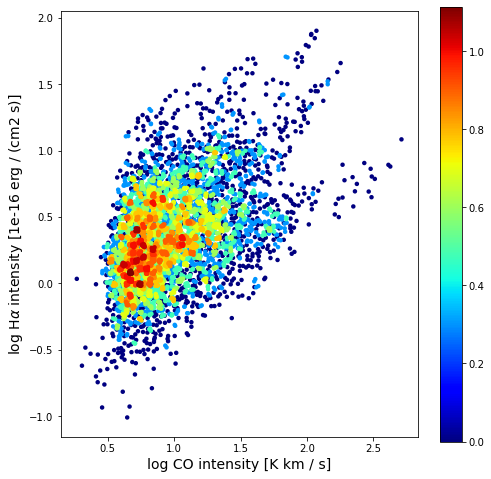

In [8]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(sfe_det['ICO'], sfe_det['IHA'], log=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='jet')
plt.xlabel('log CO intensity ['+str(sfe_det['ICO'].unit)+']',fontsize=14)
plt.ylabel(r'log H$\alpha$ intensity ['+str(sfe_det['IHA'].unit)+']',fontsize=14)
plt.colorbar(sc)

## Spatially resolved star formation law (extinction corrected)

==CO Detections==
Number of valid, invalid values: 4967 0
==Non-detections==
Number of valid, invalid values: 15527 0


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


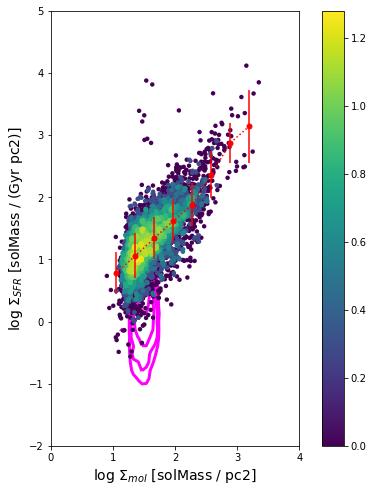

In [9]:
# Select data to plot (must be loggable)
valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(valid)[0]),len(np.nonzero(~valid)[0]))
valid_ndet = (sfe_ndet['sigmol'] > 0) & (sfe_ndet['sigsfr'] > 0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(valid_ndet)[0]),len(np.nonzero(~valid_ndet)[0]))

# Get the plotting arrays
x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                     sfe_det['sigsfr'][valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet['sigmol'][valid_ndet], 
                                         sfe_ndet['sigsfr'][valid_ndet], log=True, bins=[10,30])

# Make the scatter plot (physical values)
fig, ax = plt.subplots(figsize=(8,8))
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='viridis')
x_bin, y_bin, y_err = xy2binned(sfe_det['sigmol'][valid], sfe_det['sigsfr'][valid], bins=8)
ax.errorbar(x_bin, y_bin, yerr=y_err, color='r', marker='o', ms=5, ls=':', label='all')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0,4)
ax.set_ylim(-2,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.colorbar(sc)

## Separated by stellar mass [cf. Fig. 17(a) of Bolatto+17]

Points from high-mass galaxies: 2708
Points from low-mass galaxies: 2223


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


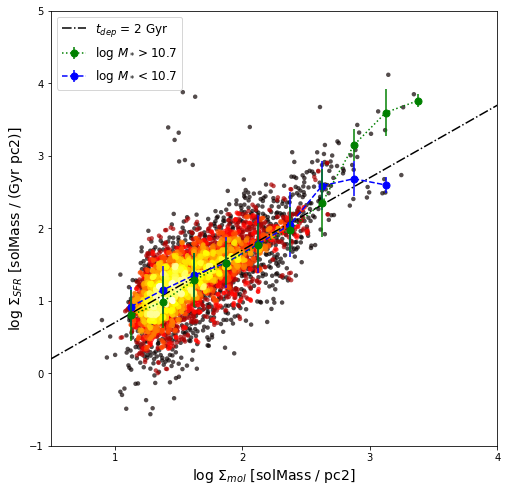

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
xlims = [0.5, 4]
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap='hot', alpha=0.7)

himass = valid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigmol'][himass], 
                                      sfe_det['sigsfr'][himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigmol'][lomass], 
                                      sfe_det['sigsfr'][lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

# 2 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(2)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')

plt.xlabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=14)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Depletion time vs. local stellar density

==CO Detections==
Number of valid, invalid values: 4967 0
Points from high-mass galaxies: 2708
Points from low-mass galaxies: 2223
==Non-detections==
Number of valid, invalid values: 15440 87


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


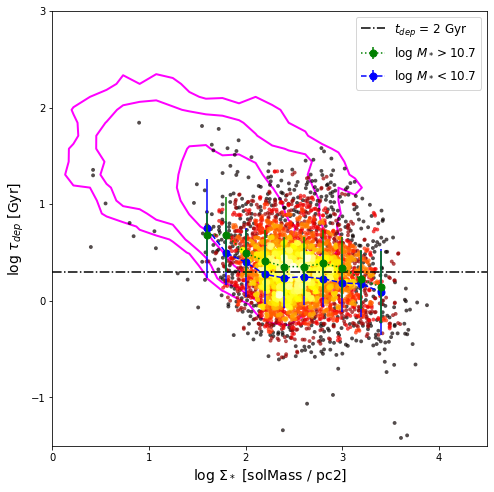

In [11]:
# Select data to plot (must be loggable)
sstd_valid = ~np.isnan(sfe_det['sigstar']) & (sfe_det['sigstar']>0) & (sfe_det['t_dep']>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(sstd_valid)[0]),len(np.nonzero(~sstd_valid)[0]))
himass = sstd_valid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = sstd_valid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))
sstd_valid_ndet = ~np.isnan(sfe_ndet['sigstar']) & (sfe_ndet['sigstar']>0) & (sfe_ndet['t_dep']>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(sstd_valid_ndet)[0]),len(np.nonzero(~sstd_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigstar'][sstd_valid], 
                                     sfe_det['t_dep'][sstd_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet['sigstar'][sstd_valid_ndet], 
                                         sfe_ndet['t_dep'][sstd_valid_ndet], 
                                         log=True, bins=[30,30])

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigstar'][himass], 
                                      sfe_det['t_dep'][himass], bins=10, range=[1.5,3.5])
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigstar'][lomass], 
                                      sfe_det['t_dep'][lomass], bins=10, range=[1.5,3.5])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('hot')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=2,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sfe_det['sigstar'].unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(sfe_det['t_dep'].unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(np.log10(2), ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Depletion time vs. local sSFR

==CO Detections==
Number of valid, invalid values: 4967 0
Points from high-mass galaxies: 2708
Points from low-mass galaxies: 2223
==Non-detections==
Number of valid, invalid values: 15440 87


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


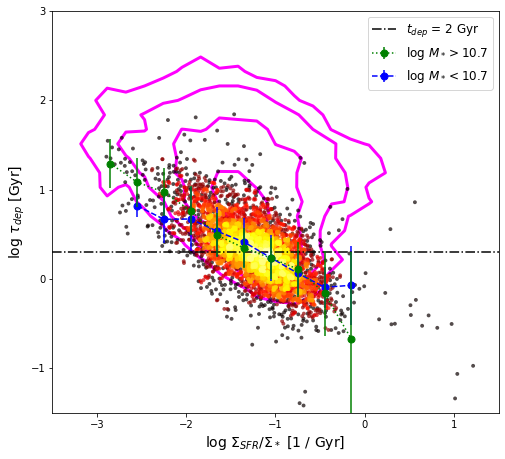

In [12]:
# Select data to plot (must be loggable)
ssft_valid = ~np.isnan(sfe_det['sigssfr']) & (sfe_det['sigssfr']>0) & (sfe_det['t_dep']>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(ssft_valid)[0]),len(np.nonzero(~ssft_valid)[0]))
himass = ssft_valid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = ssft_valid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))
ssft_valid_ndet = ~np.isnan(sfe_ndet['sigssfr']) & (sfe_ndet['sigssfr']>0) & (sfe_ndet['t_dep']>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(ssft_valid_ndet)[0]),len(np.nonzero(~ssft_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigssfr'][ssft_valid], 
                                     sfe_det['t_dep'][ssft_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet['sigssfr'][ssft_valid_ndet], 
                                         sfe_ndet['t_dep'][ssft_valid_ndet], 
                                         log=True, bins=[25,25])

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigssfr'][himass], 
                                      sfe_det['t_dep'][himass], bins=10, range=[-3,0])
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigssfr'][lomass], 
                                      sfe_det['t_dep'][lomass], bins=10, range=[-3,0])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('hot')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sfe_det['sigssfr'].unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(sfe_det['t_dep'].unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(np.log10(2), ls='-.', color='k', label='$t_{dep}$ = 2 Gyr')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## H$_2$ vs. stellar surface density relation.  Here we select only on CO detection, not H$\alpha$.

==CO Detections==
Number of valid, invalid values: 5437 222
Points from high-mass galaxies: 3064
Points from low-mass galaxies: 2336
==Non-detections==
Number of valid, invalid values: 33483 153154


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


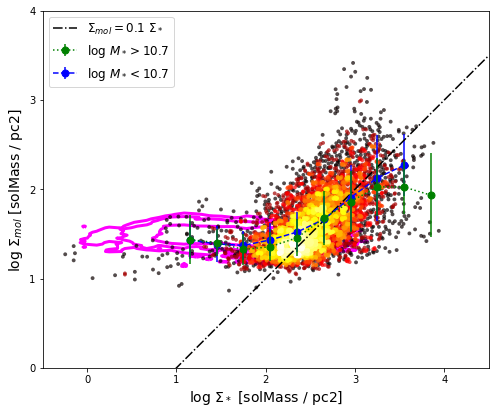

In [13]:
sigmol = fluxtab['sigmol'][codet]
sigstar = fluxtab['sigstar_sm'][codet]
h2s_valid = ~np.isnan(sigstar) & (sigmol>0) & (sigstar>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid)[0]),len(np.nonzero(~h2s_valid)[0]))
himass = h2s_valid & (fluxtab['caMass'][codet] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = h2s_valid & (fluxtab['caMass'][codet] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

sigmol_nd = msd_co(3*fluxtab['emom0max_12'][~codet])
sigstar_nd = fluxtab['sigstar_sm'][~codet]

h2s_valid_ndet = ~np.isnan(sigstar_nd) & (sigmol_nd>0) & (sigstar_nd>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid_ndet)[0]),len(np.nonzero(~h2s_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sigstar[h2s_valid], 
                                     sigmol[h2s_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sigstar_nd[h2s_valid_ndet], 
                                         sigmol_nd[h2s_valid_ndet], 
                                         log=True, bins=[40,40])

xhi_bin, yhi_bin, yhi_err = xy2binned(sigstar[himass], 
                                      sigmol[himass], bins=10, range=[1,4])
xlo_bin, ylo_bin, ylo_err = xy2binned(sigstar[lomass], 
                                      sigmol[lomass], bins=10, range=[1,4])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
xlims = [-0.5,4.5]
cm = plt.cm.get_cmap('hot')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sigmol.unit)+']',fontsize=14)
plt.ylabel(r'log $\Sigma_{mol}$ ['+str(sigstar.unit)+']',fontsize=14)
ax.set_aspect('equal')
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - 1
ax.plot(xmod, ymod, ls='-.', color='k', label='$\Sigma_{mol}=0.1\ \Sigma_*$')
ax.set_xlim(xlims)
ax.set_ylim(0,4)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')